Purpose of this document is to run 3 different implementation of BCM training: 
1. BCM training with using numpy library
2. BCM training with tensorflow without using customized classes
3. BCM training useing classes

In [1]:
%reset -f
%reload_ext autoreload

# %load BCM_running.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
%matplotlib inline
from learning_plasticity import data_loader
from learning_plasticity import BCM_cl
from learning_plasticity import BCM_fully_connect_cl as BCM
# Reset tf.app.flags.FLAGS
tf.app.flags.FLAGS = tf.python.platform.flags._FlagValues()
tf.app.flags._global_parser = argparse.ArgumentParser()

from tensorflow.python.framework import ops
ops.reset_default_graph()


Data used for training is 2D laplace data. From the input parameters, we could choose to enable skewness, rotation.

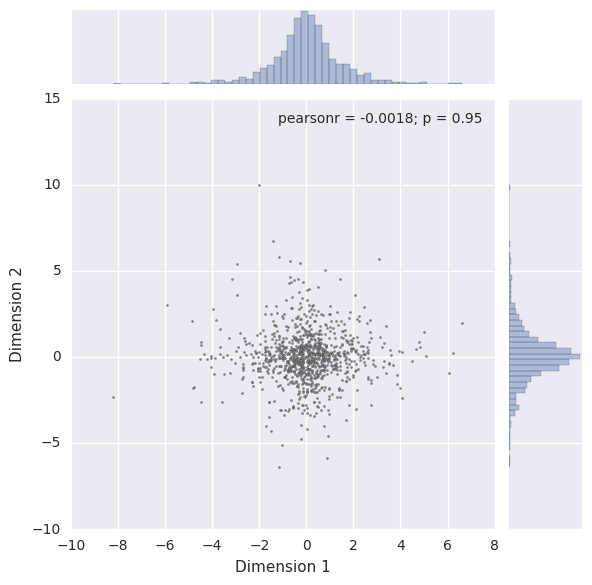

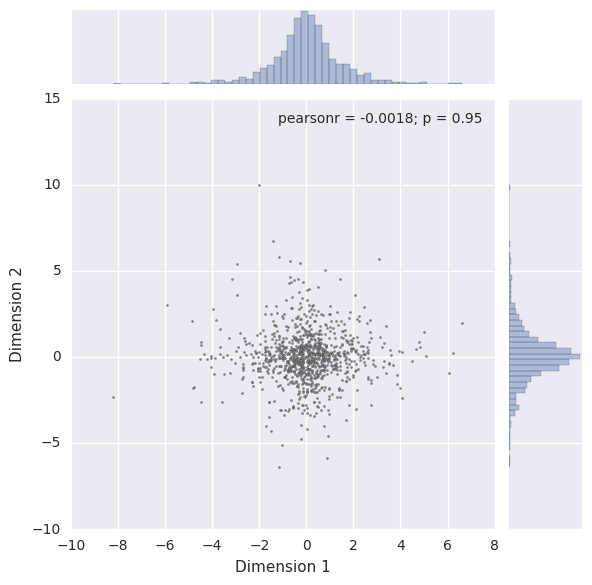

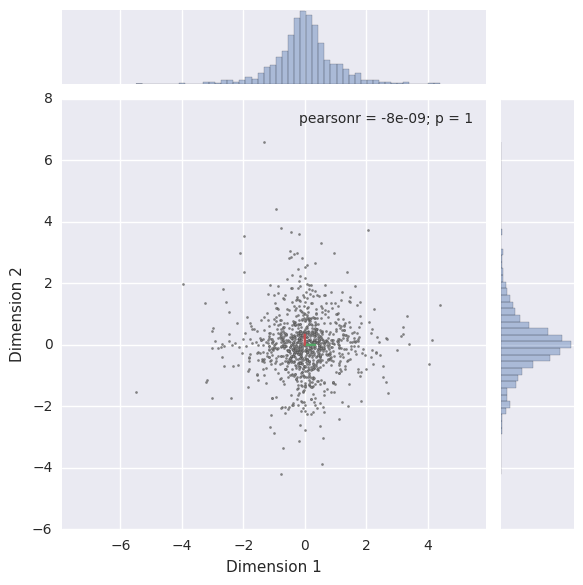

In [2]:
data, data_w = data_loader.load_laplace(loc = 0, scale = 1, sample_size = 1000 , dimension = 2,skew = False, whiten = True, rotation = False, Affine = False, iffigure = True)
# Plot the scaled version of independent direction
w_tmp = data_w
w_tmp = w_tmp * 0.5
plt.plot([0,w_tmp[0][0]],[0,w_tmp[0][1]])
plt.plot([0,w_tmp[1][0]],[0,w_tmp[1][1]])
#plt.plot(data_w[:,0], data_w[:,1],'.k', ms=4)
plt.gca().set_aspect(1)

Version 1: BCM training with numpy based classes.Used file: BCM_cl.py

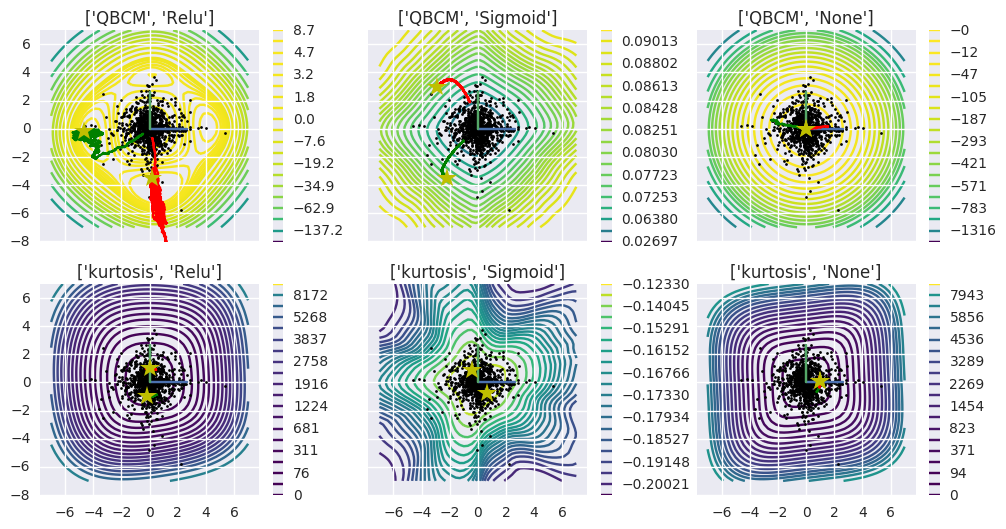

In [41]:
# Contruct objective function and 2D contour 
# Track the weight update trajectory
# Plot the trained weights on top
# Generate the objective function landscape

w_min = -7
w_max = 7
reso = 50

p = 2
ny = 2 
tau = 200
batch = 1

n_epoch = np.array([40,400,200,100,100,100])
decay = np.array([0.01,0.01,0.05,0.05,0.05,0.05])
eta = np.array([0.0005,0.01,0.001,0.0005,0.00005,0.0005])

para = [p,ny,tau,batch,n_epoch,decay,eta]

BCM_cl.bcm_obj(data,w_min,w_max,reso,para,obj_select = None, nonlinear_select = None, ori_w = data_w)

Version 2: BCM training numpy, using matrix computation for different output neurons 

/src/learning_plasticity/BCM_mat_cl.py:79: RuntimeWarning: invalid value encountered in multiply
  y_thres_mult = np.multiply(y, y_thres_diff)
/src/learning_plasticity/BCM_mat_cl.py:114: RuntimeWarning: invalid value encountered in greater_equal
  y0 = (y >= 0)


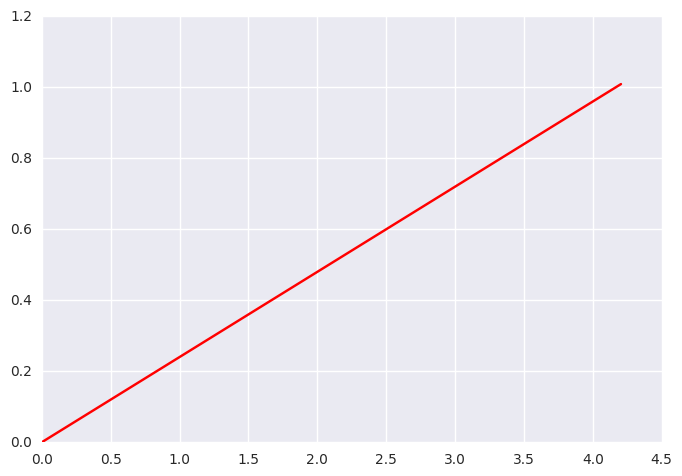

In [11]:
from learning_plasticity import BCM_mat_cl as BCM_mat

# data_loaded = np.load('data.npz')
# data, data_w = data_loaded['data'], data_loaded['data_w']
# data, data_w = data_loader.load_laplace(loc = 0, scale = 1, sample_size = 1000,dimension = 2,skew = False, whiten = True, rotation = False, iffigure = False)

dim_x = 2
n_output = 2
# eta = 0.0005
eta = 0.0000005
decay = 0.01
p = 2
tau = 200
# epoch = 100
epoch = 100
seed = 0


BCM_mat_test = BCM_mat.bcm_mat(eta=eta, n_epoch=epoch, ny=n_output, batch=1, tau=tau, thres=0, p=p, seed=seed, random_state=0,
                 nonlinear='Convex', obj_type='QBCM', decay=decay)


BCM_mat_test.fit(data)
trained_w_np = np.vstack(BCM_mat_test.w_track)

plt.plot([0, BCM_mat_test.w_[0][0]], [0, BCM_mat_test.w_[1][0]], 'r')
plt.plot([0, BCM_mat_test.w_[0][1]], [0, BCM_mat_test.w_[1][1]], 'r')

In [12]:
x = tf.random_normal([10, 10])
xv = sess.run(x)

In [47]:
data, data_w = data_loader.load_laplace(loc = 0, scale = 1, sample_size = 1000,dimension = 2,skew = False, whiten = True, rotation = False, iffigure = False)
# data, data_w = data_loader.load_Iris()
np.savez('data.npz', data=data, data_w=data_w)

In [48]:
k = np.load('data.npz')

In [49]:
k['data']

array([[-0.78763545, -1.9378492 ],
       [ 0.11275023,  0.62853376],
       [ 0.98831438,  1.24601882],
       ..., 
       [ 0.09346345,  0.53781675],
       [-1.0512088 ,  0.49986975],
       [-1.38462778, -0.26241501]])

Version 3: BCM training using tensorflow, implemented directly without calling classes

array([[ nan,  nan,  nan,  nan]])

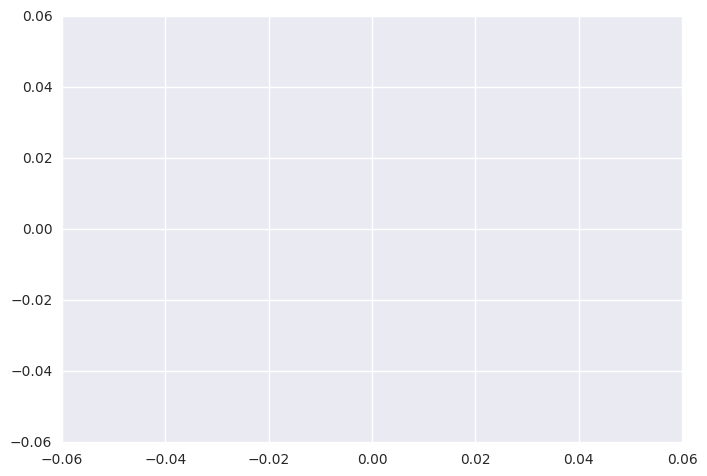

In [7]:
#data_loaded = np.load('data.npz')
#data, data_w = data_loaded['data'], data_loaded['data_w']

dim_x = 2
n_output = 2
eta = 0.0005
decay = 0.01
p = 2
tau = 200
epoch = 50
seed = 0
nonlinear = 'Convex'

sample_size = data.shape[0]

# Give input place holder

input_value = tf.placeholder(tf.float64, [1, dim_x])
obj_input = tf.placeholder(tf.float64, [sample_size, dim_x])

# Varaible
r_gen = np.random.RandomState(seed)
w = tf.Variable(r_gen.randn(dim_x, n_output), dtype=tf.float64)
# w = tf.Variable(tf.zeros([dim_x, n_output])+0.2)
# w = tf.Variable(tf.random_normal([dim_x, n_output]))
threshold = tf.Variable(tf.zeros([1, n_output], dtype=tf.float64), dtype=tf.float64)

### Computation steps
# Compute output with ReLU
net_input = tf.matmul(input_value, w)
if nonlinear == 'ReLU':
    output_value = tf.nn.relu(net_input)
elif nonlinear == 'Convex':
    output_value = tf.nn.relu(tf.square(net_input))
else:
    print('Wrong nonlinearity')

# Update weights with QBCM learning rule
out_thre_diff = output_value - threshold
out_thre_convex = tf.mul(out_thre_diff, 2 * output_value)
if nonlinear == 'Convex':
    delta_w = eta * tf.matmul(input_value, tf.mul(output_value, out_thre_convex), transpose_a = True)- eta * decay * w
elif nonlinear == 'ReLU':
    delta_w = eta * tf.matmul(input_value, tf.mul(output_value, out_thre_diff), transpose_a = True)- eta * decay * w

new_w = w + delta_w
update_w = tf.assign(w, new_w)

# Update threshold
h = tf.cast(tf.exp(-1/tau), tf.float64)
new_thres = threshold * h + tf.pow(output_value, p) * (1 - h)
update_thres = tf.assign(threshold, new_thres)

# Calculate QBCM objective function
obj_net_input = tf.matmul(obj_input, w)
obj_output = tf.nn.relu(obj_net_input)
obj1 = tf.reduce_mean(tf.pow(obj_output, 3))
obj2 = tf.reduce_mean(tf.pow(obj_output, 2))
obj = obj1/3 - tf.square(obj2)/4

# Train the model

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

w_track = []
y_track = []
thres_track = []
for i in range(epoch):
    tf.random_shuffle(data)
    for j in range(data.shape[0]):
#        print(data[j,:])
        sess.run([update_w, update_thres], feed_dict = {input_value: data[j,:].reshape(1,2)})
        #sess.run(update_thres, feed_dict = {input_value: data[j,:].reshape(1,2)})
        #sess.run(obj, feed_dict = {obj_input: data})
        w_track.append(sess.run(w).reshape(1,4))
        thres_track.append(sess.run(threshold))

# Plot the final weight
final_w = sess.run(w).reshape(1,4)
#plt.plot([0, data_w[0][0]], [0, data_w[0][1]], 'k')
#plt.plot([0, data_w[1][0]], [0, data_w[1][1]], 'k')
trained_w = np.vstack(w_track)

g = plt.gca()
plt.plot([0, final_w[0][0]], [0, final_w[0][2]], 'r')
plt.plot([0, final_w[0][1]], [0, final_w[0][3]], 'r')
final_w

In [ ]:
% debug

> <ipython-input-4-17fbede3b026>(34)<module>()
     32     output_value = tf.nn.relu(net_input)
     33 elif nonlinear == 'Convex':
---> 34     output_value == tf.nn.relu(tf.square(net_input))
     35 else:
     36     print('Wrong nonlinearity')

ipdb> exit


Version 4: BCM training with tensorflow, by calling classes. File used: BCM_tf_cl.py, BCM_fully_connect_cl.py

In [1]:
#data, data_w = data_loader.load_laplace(loc = 0, scale = 1, sample_size = 1000,dimension = 2,skew = False, whiten = True, rotation = False, iffigure = True)# Direct running of BCM in tf
#data, data_w = data_loader.load_Iris()

n_output = 2
p = 2
tau = 200
batch = 1
nonlinear = 'Convex'
obj_type = 'QBCM'
n_epoch = 100
decay = 0.01
eta = 0.0005

BCM_laplace = BCM.BCM_fully_connect(eta = eta, n_epoch = n_epoch, n_output = n_output, batch = batch, tau = tau, p = p, nonlinear = nonlinear, obj_type = obj_type, decay = decay, seed = 0, random_state = None)
BCM_laplace.run_training(data)

# plt.plot([0,data_w[0,0]], [0,data_w[0,1]],'k')
# plt.plot([0,data_w[1,0]], [0,data_w[1,1]],'k')
g = plt.gca()
# g.set_aspect(1)
trained_w_tf_cl = np.vstack(BCM_laplace.w_track)

plt.plot([0,BCM_laplace.final_w[0][0]], [0,BCM_laplace.final_w[0][2]],'r')
plt.plot([0,BCM_laplace.final_w[0][1]], [0,BCM_laplace.final_w[0][3]],'r')


NameError: name 'BCM' is not defined

Plot objective function and trajectory of the four methods

NameError: name 'trained_w_tf_cl' is not defined

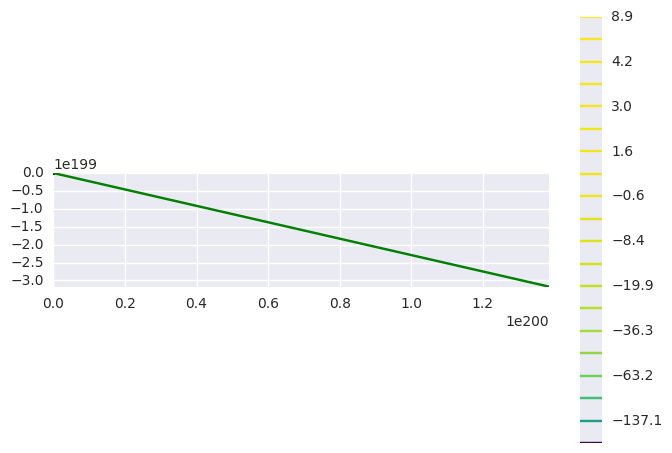

In [6]:
import seaborn as sns

#data_loaded = np.load('data.npz')
#data, data_w = data_loaded['data'], data_loaded['data_w']
sample_size = data.shape[0]
dim_x = 2
w_min = -7
w_max = 7
reso = 50

w = np.linspace(w_min, w_max, reso)
wx, wy = np.meshgrid(w, w)
w = np.vstack((wx.ravel(), wy.ravel()))

# input placeholder
obj_input = tf.placeholder(tf.float64, [sample_size, dim_x])
w_ph = tf.placeholder(tf.float64,w.shape)

# Operation
def obj(X, w, obj_type='QBCM', nonlinear='Sigmoid'):
    c = tf.matmul(X, w)
    if nonlinear == 'Sigmoid':
        c = tf.Sigmoid(c)
    elif nonlinear == 'ReLU':
        c = tf.nn.relu(c)

    obj = 0

    if obj_type == 'QBCM':
        obj1 = tf.reduce_mean(tf.pow(c, 3), 0)
        #obj1 = tf.pow(c, 3)
        obj2 = tf.reduce_mean(tf.pow(c, 2), 0)
        obj = obj1 / 3 - tf.square(obj2) / 4
    # obj = - obj2/2
    elif obj_type == 'kurtosis':
        obj1 = tf.reduce_mean(tf.pow(c, 4), 0)
        obj2 = tf.reduce_mean(tf.pow(c, 2), 0)
        obj = obj1 - tf.square(obj2)* 3
    elif obj_type == 'skewness':
        obj1 = tf.reduce_mean(tf.pow(c, 3), 0)
        obj2 = tf.reduce_mean(tf.pow(c, 2), 0)
        obj = np.divide(obj1, obj2 ** 1.5)
    else:
        print('Wrong objective function')
    
    return obj


obj_choice = ['QBCM', 'kurtosis']
nonlinear_choice = ['Relu', 'Sigmoid', 'None']

# parameter passed through para
dim_x = 2
n_output = 2
eta = 0.0005
decay = 0.01
p = 2
tau = 200
epoch = 1
seed = 0

obj_type = 'QBCM'
nonlinear = 'ReLU'

obj_landscape = obj(obj_input, w_ph, obj_type=obj_type, nonlinear=nonlinear)
obj_reshape = tf.reshape(obj_landscape, wx.shape)
sess = tf.Session()
final_obj = sess.run(obj_reshape, feed_dict = {obj_input: data, w_ph: w})
title_set = [obj_type, nonlinear]

nbins = 20
levels = np.percentile(final_obj, np.linspace(0, 100, nbins))

fig, ax = plt.subplots(1,1)
with sns.axes_style('white'):
    g = ax

c = g.contour(wx, wy, final_obj, levels=levels, zorder=-10,cmap=plt.cm.get_cmap('viridis'))
g.plot(data[:, 0], data[:, 1], '.k', ms=4)
g.set_aspect(1)

plt.grid('on')
plt.colorbar(c, ax=g)

plt.plot([0, data_w[0][0]], [0, data_w[0][1]], 'r')
plt.plot([0, data_w[1][0]], [0, data_w[1][1]], 'g')
plt.plot(trained_w_np[:,0], trained_w_np[:,1], 'r')
plt.plot(trained_w_np[:,2], trained_w_np[:,3], 'g')
plt.plot(trained_w[:,0], trained_w[:,2], 'r')
plt.plot(trained_w[:,1], trained_w[:,3], 'g')
plt.plot(trained_w_tf_cl[:,0], trained_w_tf_cl[:,2], 'r')
plt.plot(trained_w_tf_cl[:,1], trained_w_tf_cl[:,3], 'g')


In [8]:
trained_w_np[0,1]

0.9788257803882553